# 反応経路解析 - Reaction Path Analysis

前章まで安定構造付近の挙動を見ていましたが、いよいよ本章では、物質の反応を解析していきます。


<figure style="width:450px">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Activation_energy_ja.svg/600px-Activation_energy_ja.svg.png"/>
</figure>

X→Yへの反応に伴う、活性化エネルギー $E_a$ と生成エンタルピー $\Delta H$ の関係。
[Wikipedia](https://ja.wikipedia.org/wiki/%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB:Activation_energy_ja.svg)より。

<p></p>

ある反応物Xから生成物Yができる反応過程において、その反応経路中でエネルギーが最大となる点を **遷移状態 (TS: Transition State)** と呼び、反応物・生成物から遷移状態までのエネルギー差を**活性化エネルギー (Activation energy)**  $E_a$ と呼びます。

アレニウスの式によると、反応の速度定数 $k$ は、

$$k = A \exp \left(- \frac{E_a}{k_B T} \right)$$

で決まります。ここで、

 - $A$: 頻度因子(温度に無関係な定数)
 - $E_a$: 活性化エネルギー
 - $k_B$: ボルツマン定数
 - $T$: 絶対温度

です。つまり、化学反応の起こりやすさは活性化エネルギー $E_a$ によって決まります。

反応物・生成物のエネルギーが変わることはありませんが、活性化エネルギーは周辺環境、つまり触媒の存在によって反応経路が変わることで変わります。
この活性化エネルギーが低くなるような触媒を見つけられれば、対象とする反応をより起こしやすくすることができます。


参考文献

 - [活性化エネルギー - Wikipedia](https://ja.wikipedia.org/wiki/%E6%B4%BB%E6%80%A7%E5%8C%96%E3%82%A8%E3%83%8D%E3%83%AB%E3%82%AE%E3%83%BC)
 - [アレニウスの式 - Wikipedia](https://ja.wikipedia.org/wiki/%E3%82%A2%E3%83%AC%E3%83%8B%E3%82%A6%E3%82%B9%E3%81%AE%E5%BC%8F)
 - 「分子レベルで見た触媒の働き　反応はなぜ速く進むのか」 松本吉泰
 - 「熱力学で理解する化学反応のしくみ」 平山令明

反応物X、生成物Yがわかっていたとしても、遷移状態を見つけることは自明ではありません。<br/>
本節では、反応前後の構造がわかっているときにその反応途中の経路を探索するNEB (Nudged Elastic Band)法を用いて、活性化エネルギーの算出を行ってみます。

 - https://databases.fysik.dtu.dk/ase/ase/neb.html

## NEB

<figure style="width: 720px">
　　　　<img src="../assets/neb-small-720.png" style="width: 720px"/>
  <figcaption>
      NEB法のイメージ図: 初期配置として反応経路候補(赤線)を生成後、構造緩和を行い遷移状態を通るような反応経路(青線)を探索する
  </figcaption>
</figure>

※ 以下の内容はMatlantis製品内に含まれるNEB Tutorialとほぼ同じ内容です。

今回は、クルチウス転位と呼ばれる有機化学反応の一例を題材にします。

NEB法では、ある注目したい反応についてその前後の構造からスタートしますが、今回は直接構造を書き下して構造を設定します。

In [1]:
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt

import ase
from ase import Atoms
from ase.visualize import view
from ase.optimize import BFGS
from ase.optimize import FIRE
from ase.neb import NEB
from ase.build.rotate import minimize_rotation_and_translation

from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode


estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="v2.0.0")
calculator = ASECalculator(estimator)

In [2]:
react = ase.Atoms(
    symbols="C2NON2H3",
    positions = [
        [ 2.12, -0.48,  0.00],
        [ 0.76,  0.16, -0.00],
        [-0.28, -0.79, -0.00],
        [ 0.57,  1.35,  0.00],
        [-1.42, -0.28,  0.00],
        [-2.48,  0.07,  0.00],
        [ 2.67, -0.14, -0.88],
        [ 2.06, -1.57, -0.00],
        [ 2.67, -0.14,  0.88],
    ],
)

prod = ase.Atoms(
    symbols="C2NON2H3",
    positions=[
        [ 2.30, -0.87,  0.00],
        [ 0.68,  0.92, -0.00],
        [ 0.99, -0.25,  0.00],
        [ 0.25,  2.03,  0.00],
        [-2.34,  0.11,  0.00],
        [-3.13, -0.67, -0.00],
        [ 2.87, -0.57, -0.89],
        [ 2.19, -1.96,  0.00],
        [ 2.87, -0.57,  0.89],
    ],
)

まずは構造最適化計算を行います。構造最適化計算のやり方は今までと同様です。

また、後の作業のため、`minimize_rotation_and_translation` methodを用いて、反応前後の2つの構造がなるべく近くなるように位置を移動させておきます。

In [3]:
react.calc = calculator
opt = BFGS(react)
opt.run(fmax=0.01)

prod.calc = calculator
opt = BFGS(prod)
opt.run(fmax=0.01)

minimize_rotation_and_translation(react, prod)

      Step     Time          Energy         fmax
BFGS:    0 07:11:23      -41.288279        3.3720
BFGS:    1 07:11:23      -41.050347        9.2272
BFGS:    2 07:11:24      -41.352632        0.9379
BFGS:    3 07:11:24      -41.360422        0.8468
BFGS:    4 07:11:24      -41.367067        0.4149
BFGS:    5 07:11:24      -41.370915        0.2225
BFGS:    6 07:11:25      -41.373628        0.1877
BFGS:    7 07:11:25      -41.374702        0.1327
BFGS:    8 07:11:25      -41.375998        0.1432
BFGS:    9 07:11:25      -41.377709        0.1950
BFGS:   10 07:11:26      -41.379433        0.1925
BFGS:   11 07:11:26      -41.380617        0.1081
BFGS:   12 07:11:26      -41.381467        0.0848
BFGS:   13 07:11:27      -41.382043        0.0992
BFGS:   14 07:11:27      -41.382362        0.0638
BFGS:   15 07:11:27      -41.382599        0.0515
BFGS:   16 07:11:27      -41.382840        0.0601
BFGS:   17 07:11:28      -41.383157        0.0738
BFGS:   18 07:11:28      -41.383481        0.0658
B

可視化を行い、反応前後の構造を確認します。

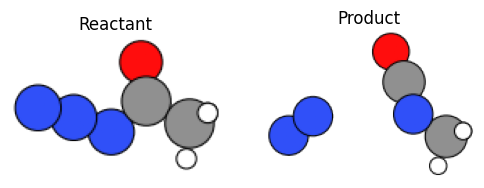

In [4]:
from ase.io import write
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

write("output/curtius_react.png", react, rotation="0x,0y,0z")
write("output/curtius_prod.png", prod, rotation="0x,0y,0z")

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
ax0, ax1 = axes
ax0.imshow(mpimg.imread("output/curtius_react.png"))
ax0.set_axis_off()
ax0.set_title("Reactant")
ax1.imshow(mpimg.imread("output/curtius_prod.png"))
ax1.set_axis_off()
ax1.set_title("Product")
fig.show()

In [5]:
from pfcc_extras.visualize.view import view_ngl

view_ngl([react, prod], representations=["ball+stick"], replace_structure=True)

ここからがNEB法の出番です。NEB法は、反応の前後の構造を離散的に補完した構造を多数用意し、それら複数の構造を位相空間上で互いに結合させつつ構造最適化を行うことで反応経路を探す手法です。

中間点の補完やNEBの実行そのもののはASEの組み込みのものを使うことができます。<br/>
以下の例のように、`allow_shared_calculator=False`を指定し、各 `image` に対して個別のCalculatorをセットすることで高速化が可能です。

NEBは複数の構造を内部で使う手法のため、MD計算などと比較するとステップあたりの計算時間は大きくなります。<br/>
従来、DFTなどの量子計算手法を用いる場合は数日から数ヶ月かかることもありますが、Matlantisでは本例では数分とかからずに終わらせることができます。

計算は以下のようなステップで行われています。

 - まず `images` としてASE Atomsのリストを作成します。
   - 最初が反応物 `react`で、最後が生成物 `prod` になるようにします。
   - 中間 `image` は後の `neb.interpolate()` で座標値が変更されるので、ここではコピーを作成しておきます。
   - 今回は、中間 `image`を7つ、合計9つで `images` を作成しました。
 - それぞれの Atoms に対して `calculator` を作成し、セットします。
 - [NEBクラス](https://databases.fysik.dtu.dk/ase/ase/neb.html)を作成します。
     - `k`が各 `images`をつなげるバネの強さを表すバネ定数です
     - `climb=True` とすることで、Climbing Image NEB法と呼ばれる、遷移状態を見つけるためにエネルギー勾配を上る手法を用いています。
 - `neb.interpolate()`
     - ここで `images` の線形補間をおこない、生成物から反応物へ座標が徐々に変わるようなリストを作成しています。
     - この時点で生成された反応経路の初期配置(候補)は、コメントアウトしてある `view_ngl` の可視化を行うことで、確認できます。
 - FIREでopt
     - 得られた反応経路候補をFIRE法を用いて最適化することで、適切な反応経路に修正していきます。

In [6]:
images = [react.copy()]
images += [react.copy() for i in range (7)]
images += [prod.copy()]
for image in images:
    estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="v2.0.0")
    calculator = ASECalculator(estimator)
    image.calc = calculator
neb = NEB(images, k=0.1, climb=True, allow_shared_calculator=False, parallel=True)
neb.interpolate()
# Check interpolated images
# view_ngl(images, representations=["ball+stick"], replace_structure=True)
opt = FIRE(neb)
status = opt.run(fmax=0.05, steps=500)

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 07:13:17      -38.199767*      23.4912
FIRE:    1 07:13:17      -39.254614*       6.5052
FIRE:    2 07:13:18      -39.008607*      11.1636
FIRE:    3 07:13:18      -39.405843*       7.0572
FIRE:    4 07:13:18      -39.450036*       6.9048
FIRE:    5 07:13:18      -39.462446*       5.3536
FIRE:    6 07:13:19      -39.478978*       3.7188
FIRE:    7 07:13:19      -39.489785*       3.0161
FIRE:    8 07:13:19      -39.491196*       2.8974
FIRE:    9 07:13:20      -39.488352*       3.9156
FIRE:   10 07:13:20      -39.488611*       4.0391
FIRE:   11 07:13:20      -39.495302*       3.5124
FIRE:   12 07:13:21      -39.507837*       2.8101
FIRE:   13 07:13:21      -39.519245*       1.8177
FIRE:   14 07:13:21      -39.525173*       3.2658
FIRE:   15 07:13:21      -39.539541*       2.8926
FIRE:   16 07:13:22      -39.572465*       1.9634
FIRE:   17 07:13:22      -39.604970*       2.3038
FI

もしログを抑制したい場合は、`FIRE(neb, logfile=None)`のような指定をするとデフォルトのoptのログが表示されなくなります。

結果を見てみましょう。以下はmatplotlibを用いてエネルギーの軌跡を可視化したものです。

エネルギーが一度上がった後で下がる反応が見えていると思います。
このエネルギーが最大の点(遷移状態、transition state)と左右の安定点それぞれとのエネルギー差が活性化エネルギーに相当します。

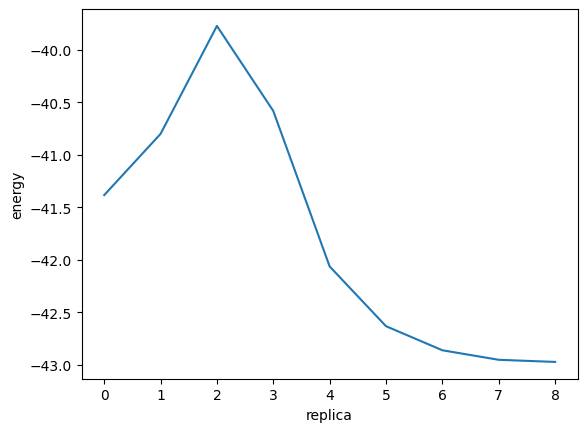

In [7]:
energies = np.array([image.get_total_energy() for image in images])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(energies)
ax.set_xlabel("replica")
ax.set_ylabel("energy")
fig.show()

活性化エネルギーは以下のように計算できます。

ここでは、順反応X→Yにおける活性化エネルギーを `E_act_forward`、逆反応Y→Xにおける活性化エネルギーを `E_act_backward`としています。

In [8]:
# Transition state takes maximum energy in the reaction path
ts_index = np.argmax(energies)

E_act_forward = energies[ts_index] - energies[0]
E_act_backward = energies[ts_index] - energies[-1]

print(f"ts_index       = {ts_index}")
print(f"E_act_forward  = {E_act_forward:.2f} eV")
print(f"E_act_backward = {E_act_backward:.2f} eV")

ts_index       = 2
E_act_forward  = 1.61 eV
E_act_backward = 3.20 eV


結果を見てみましょう。構造についても同様にNotebookに可視化してもいいですが、画像をファイルとして保存することもできます。今回は試しにそちらを実行してみましょう。

今回はNEBのため、結果は構造1つではなく一組の軌跡として出力されています。ASEからアニメーションGIFとして保存してみましょう。

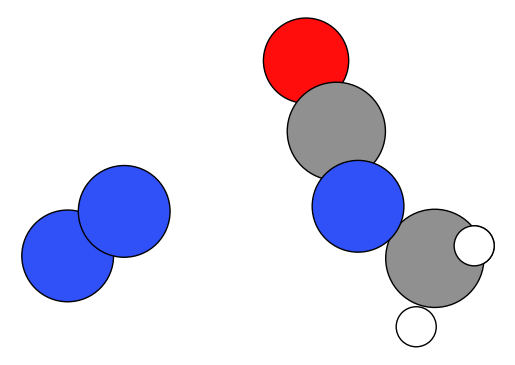

In [9]:
fig = plt.figure(facecolor="white")
ax = fig.add_subplot()
ase.io.write(
    "output/curtius_NEB.gif",
    images,
    format="gif",
    ax=ax
)

上には最終構造の静止画が表示されていると思いますが、左のファイルビューアから"curtius_NEB.gif"をダブルクリックして開くと直接アニメーションGIFを見ることができます。

以下のようにしてファイルの中身を表示することができます。

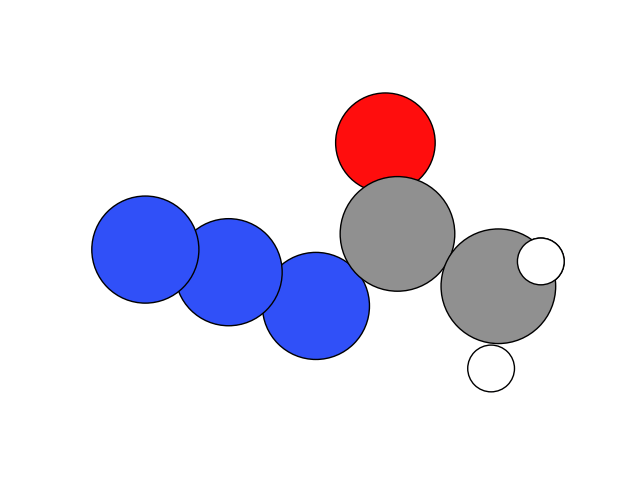

In [10]:
Image("output/curtius_NEB.gif", format="gif")

最後に追加で、NEB法により反応経路の最適化前後がどう変わったのかを比較してみましょう。

`neb.interpolate()`関数を呼び、FIRE optを行う前の反応経路の候補構造 `interpolated_images` とNEB法で最適化された後の `images` のエネルギーを比べてみます。

In [11]:
_images = [react.copy()]
_images += [react.copy() for i in range (7)]
_images += [prod.copy()]
for image in _images:
    estimator = Estimator()
    calculator = ASECalculator(estimator)
    image.calc = calculator
neb = NEB(_images, k=0.1, climb=True, allow_shared_calculator=False, parallel=True)
neb.interpolate()
interpolated_images = _images

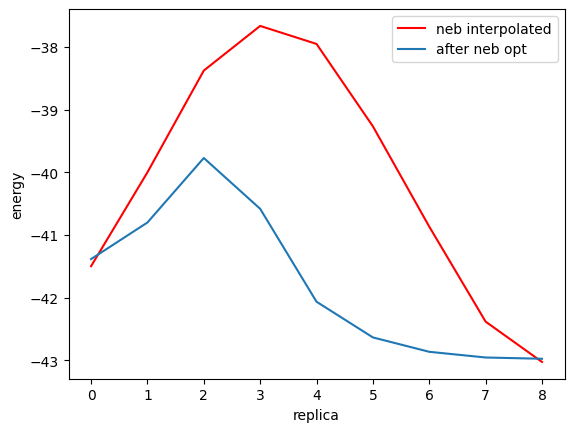

In [12]:
initial_energies = [image.get_total_energy() for image in interpolated_images]
opt_energies = [image.get_total_energy() for image in images]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(initial_energies, label="neb interpolated", color="red")
ax.plot(energies, label="after neb opt")
ax.set_xlabel("replica")
ax.set_ylabel("energy")
ax.legend()
fig.show()

上記図からもわかるように、NEBの反応経路探索により、反応経路の候補構造(赤線)よりも活性化エネルギーエネルギーが低くなる経路=遷移状態のエネルギーが低い経路(青線) が見つかったことがわかります。

## [コラム] 反応経路解析手法と分子動力学法の比較

本節では、反応を見るために始状態・終状態を指定したNEB法により反応経路の探索を行いました。

次章で説明するような分子動力学法では、原子の時間発展を追うことができますが、そのような形でシミュレーションを行い自然と反応が起きるまで待つというアプローチはどうでしょうか？<br/>
この方法でも活性化エネルギーの解析ができる例はあり、以下のLi ionの拡散現象はそのような例となります。

 - [硫化物固体電解質中のLi拡散 | MATLANTIS](https://matlantis.com/ja/calculation/li-diffusion-in-li10gep2s12-sulfide-solid-electrolyte)

しかし、一般的には**反応時間**が課題となります。<br/>
反応というのはレアイベントです。<br/>
アレニウスの式を見ても分かる通り、活性化エネルギー $E_a$ に対して指数関数的に発生頻度が変わる現象です。

$$k = A \exp \left(- \frac{E_a}{k_B T} \right)$$

そのため、活性化エネルギーがとても低い場合はMDでもその反応を見ることができますが、
すこしでも高くなってくると、MDで扱える時間スケール (〜ns程度)ではその反応が起きず、効率的に見つけることはできません。
さらに活性化エネルギーが高くなれば日常の世界でもおこらないような現象となります。


参考までに、具体的な値を通して活性化エネルギーと現象の起こりやすさの関係を見てみましょう。ほぼ室温である300 Kでは、アレニウスの式の指数関数内部の分母にあたる$k_B T$の値はおおまかに0.026 eVとなります。これは、エネルギーが1 eV高い現象の起きやすさが$\exp\left(-1/0.026\right)$倍、つまり$2\times10^{-17}$倍に下がるということを意味します。これはマクロスケールと原子スケールの差を考慮してもなお大きな値であり、レアイベントとみなすことができます。
同様に計算すると、温度が1000 Kおよび2000 Kの場合は$k_B T$はそれぞれ0.086 eV, 0.172 eVとなり、エネルギーが1 eV高い現象の起きやすさはそれぞれ約$9\times10^{-6}$倍、 $0.003$倍となります。これは300 Kのときの値と比べると大幅に大きくなっており、マクロスケールでは頻繁に起きる現象とみなすことができます。このように、一般に現象の起きやすさは活性化エネルギーと温度に対して非常に鋭敏に変化するものであることが知られています。
NEB法のような反応経路解析を使うことによって、このような指数関数スケールにまたがるレアイベントを効率的に分析することが可能となります。

In [13]:
from ase.units import kB
from math import exp

for T in [300, 1000, 2000]:
    kBT = kB * T
    ratio = exp(-1 / (kBT))

    print(f"----- T = {T} K -----")
    print(f"kB T : {kBT:.3f}")
    print(f"ratio: {ratio:.2e}")

----- T = 300 K -----
kB T : 0.026
ratio: 1.59e-17
----- T = 1000 K -----
kB T : 0.086
ratio: 9.12e-06
----- T = 2000 K -----
kB T : 0.172
ratio: 3.02e-03


このように、MDではみることが難しいような反応も、NEB法などを使うことで効率的に探索することができる可能性があります。

この他、反応経路探索に関するいくつかのアプローチ方法を以下に記載します。

<table>
  <tr>
    <th width="250">アプローチ</th>
    <th >特徴</th>
    <th width="150">手法例</th>
  </tr>
  <tr>
    <td>特定の反応経路を対象とする反応経路探索</td>
    <td>ある2つの安定構造をつなぐ経路を出発点として、近傍の最小エネルギー経路(MEP: Minimum Energy Path)を求める手法。比較的少ない計算コストでMEPおよび対応する遷移状態を見つけられるが、いわゆる局所探索のため、結果は探索前に想定した反応経路に強く依存する。</td>
    <td>NEB法・String法など</td>
  </tr>
  <tr>
    <td>反応経路を事前に想定しない反応経路探索</td>
    <td>反応経路や反応後の構造を事前に仮定せずに、反応経路を1つ以上見つける方法。標準的なMDを行う方法以外に、効率的にエネルギー曲面を探索することを目的としたメタダイナミクス、局所的なエネルギー曲面の情報を使って探索する手法(ADDF)などがある。</td>
      <td>MD、メタダイナミクス、ADDFなど</td>
  </tr>
</table>

## 参考文献

反応経路探索手法についてさらに知りたい方は、以下の文献も参考になるでしょう。

 - [新しい材料を化学反応でつくる | HPCシステムズ・計算化学ソリューション](https://www.hpc.co.jp/chem/library/c_irc/)
 - [GRRM : Global Reaction Route Mapping](https://iqce.jp/GRRM/)